# 👩‍💻 개인 프로젝트(기여도 100%)

# 📑 활용 데이터 - Kaggle 'CTR In Advertisement'

- 세션 정보, 고객 정보, 웹페이지 정보, 캠페인 정보, 클릭 여부 정보 제공

# 1. 라이브러리 임포트

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette('husl'))

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import levene
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 전처리

In [2]:
# 데이터 불러오기

df = pd.read_csv('./data/Ad_click_prediction_train.csv')
df.head(2)

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0


In [3]:
# 중복 제거

df = df.drop_duplicates()

In [4]:
# 결측치 확인

df.isna().sum()

session_id                     0
DateTime                       0
user_id                        0
product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        365854
user_group_id              18243
gender                     18243
age_level                  18243
user_depth                 18243
city_development_index    125129
var_1                          0
is_click                       0
dtype: int64

In [5]:
# user_group_id, gender, age_level, user_depth가 결측치인 데이터 제거

df = df[df['user_group_id'].notna()]

In [6]:
df.isna().sum()

session_id                     0
DateTime                       0
user_id                        0
product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        351379
user_group_id                  0
gender                         0
age_level                      0
user_depth                     0
city_development_index    106886
var_1                          0
is_click                       0
dtype: int64

In [7]:
# DateTime 컬럼을 날짜 형식으로 변경

df['DateTime'] = pd.to_datetime(df['DateTime'])

In [8]:
# 시간 컬럼 추가

df['hour'] = df['DateTime'].dt.hour

In [9]:
# webpage_id & campaign_id 관계 확인 --> webpage_id 13787에는 2개의 campaign이 존재, 나머지는 모두 1개의 campaign만 존재

pd.crosstab(df['campaign_id'], df['webpage_id'])

webpage_id,1734,6970,11085,13787,28529,45962,51181,53587,60305
campaign_id,,,,,,,,,
82320,26016,0,0,0,0,0,0,0,0
98970,0,33904,0,0,0,0,0,0,0
105960,0,0,24873,0,0,0,0,0,0
118601,0,0,0,0,34822,0,0,0,0
359520,0,0,0,104544,0,0,0,0,0
360936,0,0,0,50048,0,0,0,0,0
396664,0,0,0,0,0,0,23241,0,0
404347,0,0,0,0,0,0,0,27376,0
405490,0,0,0,0,0,0,0,0,92168


In [10]:
# 분석에 필요한 컬럼만 남기기 --> feature 10개, label 1개

df = df[['user_id', 'user_group_id', 'user_depth', 'gender', 'age_level',
         'hour', 'product', 'webpage_id', 'campaign_id', 'var_1', 'is_click']]

In [11]:
# 최종 데이터 확인

df.head(2)

,user_id,user_group_id,user_depth,gender,age_level,hour,product,webpage_id,campaign_id,var_1,is_click
0,858557,10.0,3.0,Female,4.0,0,C,13787,359520,0,0
1,243253,8.0,2.0,Female,2.0,0,C,11085,105960,0,0


# 3. session별 CTR
광고를 본 사용자가 해당 광고를 클릭하는 빈도(클릭수 / 노출수)

In [12]:
# 6.75%로 매우 높음

round(df['is_click'].sum() / len(df) * 100, 2)

6.75

In [13]:
# 어떤 feature가 is_click과 연관이 있을까?
# feature가 모두 범주형 변수이므로 카이제곱독립성 검정 & Cramer's V 상관계수 분석으로 확인
# Cramer's V 상관계수가 높은 순서(상관관계가 높은 순서)로 정렬
# --> user_depth를 제외한 모든 변수가 is_click과 상관관계가 있으며 user_id가 가장 높은 연관성을 보임

features = df.columns[:-1]
data = []

for feature in features:
    chi2 = chi2_contingency(pd.crosstab(df[feature], df['is_click']))
    cramer = association(pd.crosstab(df[feature], df['is_click']), method='cramer')
    if chi2[1] <= 0.05:
        data.append({'feature': feature, "Cramer's V": cramer, 'p-value': round(chi2[1], 4), 'correlation': 'O'})
    else:
        data.append({'feature': feature, "Cramer's V": cramer, 'p-value': round(chi2[1], 4), 'correlation': 'X'})

pd.DataFrame(data).sort_values("Cramer's V", ascending=False)

,feature,Cramer's V,p-value,correlation
0,user_id,0.636212,0.0000,O
8,campaign_id,0.059529,0.0000,O
7,webpage_id,0.057661,0.0000,O
6,product,0.026463,0.0000,O
1,user_group_id,0.021616,0.0000,O
4,age_level,0.020995,0.0000,O
5,hour,0.013043,0.0000,O
9,var_1,0.011910,0.0000,O
3,gender,0.004460,0.0030,O
2,user_depth,0.003542,0.0613,X


In [14]:
# is_click과 관련 없는 user_depth 삭제

df.drop(columns=['user_depth'], inplace=True)

# 4. user별 CTR
개별 사용자의 클릭률(클릭수 / 사용자에게 노출된 광고수)

## (1) EDA

In [15]:
# user_id별 CTR df 생성

df2 = df.groupby(['user_id', 'gender'], as_index=False).agg(impressions=('is_click', 'count'), clicks=('is_click','sum'))
df2['ctr'] = df2['clicks'] / df2['impressions'] * 100
df2.head()

,user_id,gender,impressions,clicks,ctr
0,4,Female,1,0,0.0
1,6,Male,1,0,0.0
2,19,Male,2,0,0.0
3,25,Male,2,0,0.0
4,26,Male,1,0,0.0


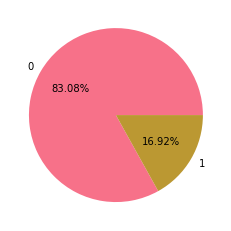

In [16]:
# 한 번이라도 클릭한 user --> 16.92%

User = [len(df2[df2['ctr'] == 0]), len(df2[df2['ctr'] != 0])]
plt.pie(User, labels=[0, 1], autopct='%.2f%%')
plt.show()

In [17]:
# 한 번이라도 클릭한 user의 CTR --> 7.9%로 매우 높음

round(df2['ctr'].mean(), 2)

7.9

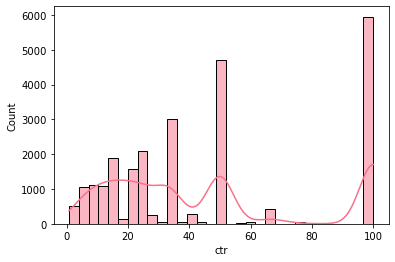

In [18]:
# 분포 확인

sns.histplot(df2.loc[df2['ctr'] != 0, 'ctr'], kde=True)
plt.show()

## (2) 어떤 성별이 광고를 더 많이 클릭할까?
- 여성 CTR 7.33%, 남성 CTR 7.98%
- 독립 2표본 t검정(양측꼬리) 실행, p-value 0.0003 < 0.05로 귀무가설 기각
### ⇒ 남성이 광고를 더 많이 클릭함

In [19]:
# 여: 7.33%

f = df2.loc[df2['gender'] == 'Female', 'ctr']
round(f.mean(), 2)

7.33

In [20]:
# 남: 7.98%
    
m = df2.loc[df2['gender'] == 'Male', 'ctr']
round(m.mean(), 2)

7.98

In [21]:
# 독립 t검정 실행
# 그룹간 등분산 검정 --> 이분산

levene(f, m)[1].round(4)

0.0004

In [22]:
# 귀무가설 기각 --> 성별에 따른 CTR에 차이가 있다.

ttest_ind(f, m, equal_var=False)[1].round(4)

0.0003

# 5. campaign CTR 분석

## (1) campaign별 노출, 도달, 빈도 및 CTR

In [23]:
# 노출(impression) --> 광고가 잠재고객에게 몇 번 보여졌는가?

Impression = df.groupby(['webpage_id','campaign_id'])['user_id'].count().reset_index()
Impression = Impression.rename(columns={'user_id': 'impression'})
Impression

,webpage_id,campaign_id,impression
0,1734,82320,26016
1,6970,98970,33904
2,11085,105960,24873
3,13787,359520,104544
4,13787,360936,50048
5,28529,118601,34822
6,45962,414149,28056
7,51181,396664,23241
8,53587,404347,27376
9,60305,405490,92168


In [24]:
# 도달(reach) --> 광고가 몇 명의 잠재고객에게 보여졌는가?

Reach = df.groupby('campaign_id')['user_id'].nunique().reset_index()
Reach = Reach.rename(columns={'user_id': 'reach'})
Reach

,campaign_id,reach
0,82320,12351
1,98970,21066
2,105960,13604
3,118601,14821
4,359520,47519
5,360936,29038
6,396664,14245
7,404347,15359
8,405490,55399
9,414149,13272


In [25]:
# 빈도(frequency) --> 노출 / 도달. 1인당 노출 횟수. 한 고객에게 같은 광고가 보이는 횟수.

Campaign = pd.merge(left=Impression, right=Reach, on='campaign_id')
Campaign['frequency'] = (Campaign['impression'] / Campaign['reach']).round(2)
Campaign

,webpage_id,campaign_id,impression,reach,frequency
0,1734,82320,26016,12351,2.11
1,6970,98970,33904,21066,1.61
2,11085,105960,24873,13604,1.83
3,13787,359520,104544,47519,2.20
4,13787,360936,50048,29038,1.72
5,28529,118601,34822,14821,2.35
6,45962,414149,28056,13272,2.11
7,51181,396664,23241,14245,1.63
8,53587,404347,27376,15359,1.78
9,60305,405490,92168,55399,1.66


In [26]:
# CTR

CTR = (df.groupby('campaign_id')['is_click'].sum() / df.groupby('campaign_id')['is_click'].count() * 100).round(2).reset_index()
CTR = CTR.rename(columns={'is_click': 'ctr'})
CTR

,campaign_id,ctr
0,82320,6.45
1,98970,7.67
2,105960,6.81
3,118601,5.37
4,359520,5.86
5,360936,4.51
6,396664,7.21
7,404347,7.78
8,405490,9.09
9,414149,5.86


In [27]:
# 최종 데이터 확인

Campaign = pd.merge(left=Campaign, right=CTR, on='campaign_id')
Campaign

,webpage_id,campaign_id,impression,reach,frequency,ctr
0,1734,82320,26016,12351,2.11,6.45
1,6970,98970,33904,21066,1.61,7.67
2,11085,105960,24873,13604,1.83,6.81
3,13787,359520,104544,47519,2.20,5.86
4,13787,360936,50048,29038,1.72,4.51
5,28529,118601,34822,14821,2.35,5.37
6,45962,414149,28056,13272,2.11,5.86
7,51181,396664,23241,14245,1.63,7.21
8,53587,404347,27376,15359,1.78,7.78
9,60305,405490,92168,55399,1.66,9.09


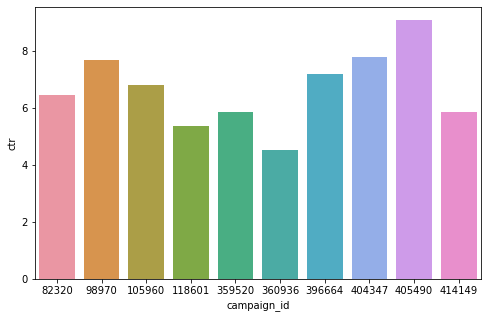

In [28]:
plt.figure(figsize=(8, 5))
sns.barplot(x=Campaign['campaign_id'], y=Campaign['ctr'])
plt.show()

## (2) 같은 webpage에서 진행한 2개의 campaign 중 더 효과적인 campaign은 무엇일까?
- webpage 13787에서 진행한 2개의 campaign 359520(CTR 6.1%), 360963(CTR 5.0%)
- 독립 2표본 t검정(양측꼬리) 실행, p-value 0.0000 < 0.05로 귀무가설 기각
### ⇒ campaign 359520이 더 효과적임

In [29]:
# campaign_id별 user별 CTR df 생성

df3 = df[['user_id', 'webpage_id', 'campaign_id', 'is_click']]
df3 = df3[df3['webpage_id'] == 13787]
df3 = df3.groupby(['user_id', 'webpage_id', 'campaign_id'], as_index=False).agg(impressions=('is_click', 'count'), clicks=('is_click','sum'))
df3['ctr'] = df3['clicks'] / df3['impressions'] * 100
df3.head()

,user_id,webpage_id,campaign_id,impressions,clicks,ctr
0,25,13787,359520,1,0,0.0
1,25,13787,360936,1,0,0.0
2,30,13787,359520,1,0,0.0
3,33,13787,359520,2,0,0.0
4,37,13787,359520,4,0,0.0


In [30]:
# campaign 359520 --> 6.1%

a = df3.loc[df3['campaign_id'] == 359520, 'ctr']
round(a.mean(), 2)

6.1

In [31]:
# campaign 360936 --> 5.0%

b = df3.loc[df3['campaign_id'] == 360936, 'ctr']
round(b.mean(), 2)

5.0

In [32]:
# 독립 t검정 실행
# 그룹간 등분산 검정 --> 이분산

levene(a, b)[1].round(4)

0.0

In [33]:
# 귀무가설 기각 --> campaign에 따른 user별 CTR에 차이가 있다.

ttest_ind(a, b, equal_var=False)[1].round(4)

0.0

# 6. CTR Prediction

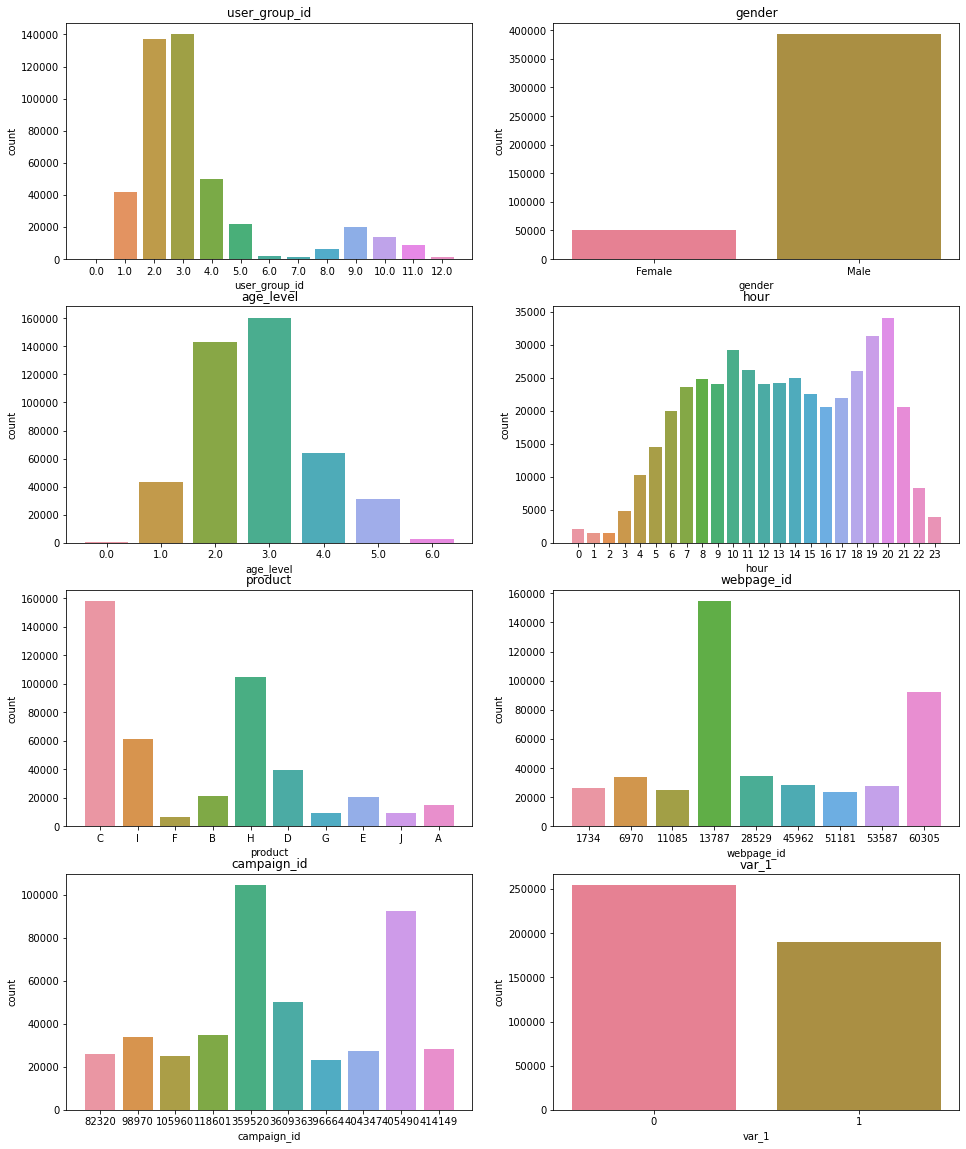

In [34]:
# feature EDA

features = df.columns[1:-1]
plt.figure(figsize=(16, 20))

for idx, feature in enumerate(features):
    plt.subplot(4, 2, idx+1)
    plt.title(feature)
    sns.countplot(x=feature, data=df)
    plt.plot()